# Clustering con Restricciones (CCKM)
**Objetivo**: Esta libreta implementa y evalúa el algoritmo `Constrained-Capacity K-Means (CCKM)`.

Compararemos tres enfoques:
- **K-Means Estándar**: Ignorar todas las restricciones
- **Baseline (Constrained K-Means)**: Una versión de nuestro algoritmo que solo maneja `Must-Link` y `Cannot-Link`, pero ignora la capacidad.
- **CCKM (Nuestra Solución)**: El algoritmo completo que maneja `Must-Link`, `Cannot-Link`, Capacidad Máxima y Capacidad Mínima.

## Celda 1. Importaciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import adjusted_rand_score
from collections import defaultdict
import warnings
import pandas as pd

## Celda 2. Código del Algoritmo (Helpers y CCKM)
Esta celda contiene las clases y funciones que desarrollamos.

In [2]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.n = n

    def find(self, i):
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i])
        return self.parent[i]

    def union(self, i, j):
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i != root_j:
            self.parent[root_i] = root_j
            return True
        return False

class ConstrainedCapacityKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, k, max_cap=np.inf, min_cap=0,
                 max_iter_kmeans=100, assign_iter=5, random_state=42):
        self.k = k
        self.max_cap = max_cap
        self.min_cap = min_cap
        self.max_iter_kmeans = max_iter_kmeans
        self.assign_iter = assign_iter
        self.random_state = random_state

        self.super_nodos_ = []
        self.cl_map_ = set()
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, ml, cl):
        n_samples = X.shape[0]
        np.random.seed(self.random_state)
        uf = UnionFind(n_samples)
        for p1, p2 in ml:
            uf.union(p1, p2)

        super_nodo_map = defaultdict(list)
        for i in range(n_samples):
            root = uf.find(i)
            super_nodo_map[root].append(i)

        self.super_nodos_ = []
        for root_id, indices in super_nodo_map.items():
            self.super_nodos_.append({
                'id': root_id,
                'indices': indices,
                'tamaño': len(indices),
                'centroide': np.mean(X[indices], axis=0)
            })

        m_super_nodos = len(self.super_nodos_)

        self.cl_map_ = set()
        for p1, p2 in cl:
            root1 = uf.find(p1)
            root2 = uf.find(p2)
            if root1 == root2:
                raise ValueError(f"Contradicción irresoluble: Puntos {p1} y {p2} tienen CL y ML.")
            if root1 > root2: root1, root2 = root2, root1
            self.cl_map_.add((root1, root2))

        super_centroides = np.array([sn['centroide'] for sn in self.super_nodos_])
        kmeans_init = KMeans(n_clusters=self.k, init='k-means++', n_init=1, random_state=self.random_state)
        kmeans_init.fit(super_centroides)
        self.cluster_centers_ = kmeans_init.cluster_centers_
        asignaciones = kmeans_init.labels_

        for iter_km in range(self.max_iter_kmeans):
            centros_antiguos = self.cluster_centers_.copy()

            for _ in range(self.assign_iter):
                cluster_info = defaultdict(lambda: {'tamaño': 0, 'super_nodos': set()})
                for sn_idx, cluster_id in enumerate(asignaciones):
                    sn_id = self.super_nodos_[sn_idx]['id']
                    sn_tamaño = self.super_nodos_[sn_idx]['tamaño']
                    cluster_info[cluster_id]['tamaño'] += sn_tamaño
                    cluster_info[cluster_id]['super_nodos'].add(sn_id)

                indices_aleatorios = np.random.permutation(m_super_nodos)

                for sn_idx in indices_aleatorios:
                    sn = self.super_nodos_[sn_idx]
                    sn_id, sn_tamaño = sn['id'], sn['tamaño']
                    cluster_actual = asignaciones[sn_idx]

                    cluster_info[cluster_actual]['tamaño'] -= sn_tamaño
                    cluster_info[cluster_actual]['super_nodos'].remove(sn_id)

                    mejor_cluster, menor_costo = -1, np.inf
                    distancias = [np.linalg.norm(sn['centroide'] - c) for c in self.cluster_centers_]

                    for cluster_j in np.argsort(distancias):
                        costo = distancias[cluster_j]
                        if cluster_info[cluster_j]['tamaño'] + sn_tamaño > self.max_cap:
                            continue

                        es_valido_cl = True
                        for otro_sn_id in cluster_info[cluster_j]['super_nodos']:
                            id1, id2 = (sn_id, otro_sn_id) if sn_id < otro_sn_id else (otro_sn_id, sn_id)
                            if (id1, id2) in self.cl_map_:
                                es_valido_cl = False; break

                        if es_valido_cl and costo < menor_costo:
                            menor_costo, mejor_cluster = costo, cluster_j

                    if mejor_cluster == -1: mejor_cluster = cluster_actual

                    asignaciones[sn_idx] = mejor_cluster
                    cluster_info[mejor_cluster]['tamaño'] += sn_tamaño
                    cluster_info[mejor_cluster]['super_nodos'].add(sn_id)

            nuevos_centros = np.zeros_like(self.cluster_centers_)
            pesos_totales = np.zeros(self.k)
            for sn_idx, cluster_id in enumerate(asignaciones):
                sn = self.super_nodos_[sn_idx]
                nuevos_centros[cluster_id] += sn['centroide'] * sn['tamaño']
                pesos_totales[cluster_id] += sn['tamaño']

            for j in range(self.k):
                if pesos_totales[j] > 0:
                    nuevos_centros[j] /= pesos_totales[j]
                else:
                    idx_mas_lejano = np.argmax([np.min(np.linalg.norm(sn['centroide'] - self.cluster_centers_[c_id])) 
                                                for sn_idx, c_id in enumerate(asignaciones) for sn in [self.super_nodos_[sn_idx]]])
                    nuevos_centros[j] = self.super_nodos_[idx_mas_lejano]['centroide']

            self.cluster_centers_ = nuevos_centros
            if np.allclose(self.cluster_centers_, centros_antiguos): break

        self.asignaciones_super_nodos_ = asignaciones
        if self.min_cap > 0:
            self._reparar_min_capacidad()

        self.labels_ = np.zeros(n_samples, dtype=int)
        for sn_idx, cluster_id in enumerate(self.asignaciones_super_nodos_):
            indices_originales = self.super_nodos_[sn_idx]['indices']
            self.labels_[indices_originales] = cluster_id

        return self

    def _reparar_min_capacidad(self):
        asignaciones = self.asignaciones_super_nodos_

        for _ in range(len(self.super_nodos_)):
            cluster_info = defaultdict(lambda: {'tamaño': 0, 'super_nodos': []})
            for sn_idx, cluster_id in enumerate(asignaciones):
                sn = self.super_nodos_[sn_idx]
                cluster_info[cluster_id]['tamaño'] += sn['tamaño']
                cluster_info[cluster_id]['super_nodos'].append(sn_idx)

            deficientes = [j for j in range(self.k) if cluster_info[j]['tamaño'] < self.min_cap]
            donantes = [j for j in range(self.k) if cluster_info[j]['tamaño'] > self.min_cap]

            if not deficientes: break

            j_def = deficientes[0]
            mejor_movimiento, min_costo_aumento = None, np.inf

            for j_don in donantes:
                if cluster_info[j_don]['tamaño'] - 1 <= self.min_cap: continue
                for sn_idx in cluster_info[j_don]['super_nodos']:
                    sn = self.super_nodos_[sn_idx]

                    if cluster_info[j_def]['tamaño'] + sn['tamaño'] > self.max_cap: continue
                    es_valido_cl = True
                    for otro_sn_idx in cluster_info[j_def]['super_nodos']:
                        otro_sn_id = self.super_nodos_[otro_sn_idx]['id']
                        id1, id2 = (sn['id'], otro_sn_id) if sn['id'] < otro_sn_id else (otro_sn_id, sn['id'])
                        if (id1, id2) in self.cl_map_: es_valido_cl = False; break
                    if not es_valido_cl: continue

                    costo_aumento = np.linalg.norm(sn['centroide'] - self.cluster_centers_[j_def]) - \
                                    np.linalg.norm(sn['centroide'] - self.cluster_centers_[j_don])

                    if costo_aumento < min_costo_aumento:
                        min_costo_aumento = costo_aumento
                        mejor_movimiento = (sn_idx, j_don, j_def)

            if mejor_movimiento:
                sn_idx_mover, j_origen, j_destino = mejor_movimiento
                asignaciones[sn_idx_mover] = j_destino
            else:
                warnings.warn(f"Heurística MinCap: No se pudo reparar el cluster {j_def} "
                              f"(tamaño {cluster_info[j_def]['tamaño']}).", RuntimeWarning)
                break

        self.asignaciones_super_nodos_ = asignaciones

## Celda 3: Generación de Datos
Aquí creamos el escenario del problema: 1000 puntos, 5 clusters y las 20+30 restricciones aleatorias.

Generando 1000 puntos en 5 clusters...
Generadas 20 restricciones ML y 30 restricciones CL.


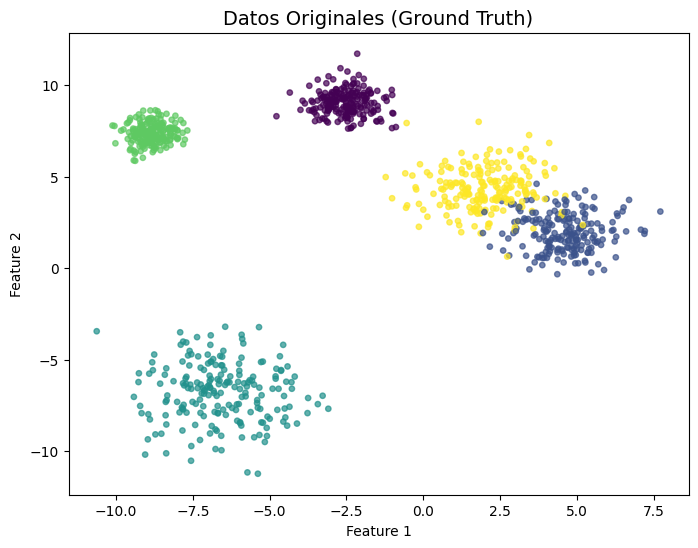

In [3]:
def generar_datos_desafio(n_puntos=1000, n_ml=20, n_cl=30):
    print(f"Generando {n_puntos} puntos en 5 clusters...")
    X, y_true = make_blobs(n_samples=n_puntos, centers=5, n_features=2,
                           cluster_std=[0.7, 1.0, 1.5, 0.5, 1.2], random_state=42)

    indices = list(range(n_puntos))

    ml_links = set()
    while len(ml_links) < n_ml:
        p1, p2 = np.random.choice(indices, 2, replace=False)
        if p1 > p2: p1, p2 = p2, p1
        ml_links.add((p1, p2))

    cl_links = set()
    while len(cl_links) < n_cl:
        p1, p2 = np.random.choice(indices, 2, replace=False)
        if p1 > p2: p1, p2 = p2, p1
        if (p1, p2) not in ml_links:
            cl_links.add((p1, p2))

    print(f"Generadas {len(ml_links)} restricciones ML y {len(cl_links)} restricciones CL.")
    return X, y_true, list(ml_links), list(cl_links)

X, y_true, ml, cl = generar_datos_desafio(n_puntos=1000, n_ml=20, n_cl=30)

K = 5
MAX_CAP = 250
MIN_CAP = 150

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=15, alpha=0.7)
plt.title('Datos Originales (Ground Truth)', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Celda 4: Definición y Ejecución de Modelos
Ahora entrenamos los tres modelos que queremos comparar.

In [4]:
print("Entrenando los 3 modelos...")

print("1. K-Means Estándar (ignora todo)")
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

print("2. Baseline: Constrained-KMeans (solo ML/CL)")
cop_kmeans = ConstrainedCapacityKMeans(k=K,
                                     max_cap=np.inf,
                                     min_cap=0,
                                     random_state=42)
cop_kmeans.fit(X, ml, cl)
labels_cop = cop_kmeans.labels_

print("3. Solución Completa: CCKM (con ML, CL y Capacidad)")
cckm = ConstrainedCapacityKMeans(k=K,
                                 max_cap=MAX_CAP,
                                 min_cap=MIN_CAP,
                                 random_state=42)
cckm.fit(X, ml, cl)
labels_cckm = cckm.labels_

print("\n¡Entrenamiento completado!")

resultados = {
    '1. Ground Truth': y_true,
    '2. K-Means Estándar': labels_kmeans,
    '3. Constrained-KMeans (Baseline)': labels_cop,
    '4. CCKM (Nuestra Solución)': labels_cckm
}

Entrenando los 3 modelos...
1. K-Means Estándar (ignora todo)
2. Baseline: Constrained-KMeans (solo ML/CL)
3. Solución Completa: CCKM (con ML, CL y Capacidad)

¡Entrenamiento completado!


## Celda 5: Análisis de Resultados (Métricas)
Esta es la parte más importante: la tabla de validación. Creamos una función para medir el cumplimiento de *todas* las restricciones.

In [5]:
def evaluar_restricciones(labels, ml, cl, min_cap, max_cap, y_true):
    ml_violadas = 0
    for p1, p2 in ml:
        if labels[p1] != labels[p2]:
            ml_violadas += 1

    cl_violadas = 0
    for p1, p2 in cl:
        if labels[p1] == labels[p2]:
            cl_violadas += 1

    counts = np.bincount(labels)
    cap_min_violadas = np.sum(counts < min_cap)
    cap_max_violadas = np.sum(counts > max_cap)

    ari = adjusted_rand_score(y_true, labels)

    return {
        'ML Violadas': ml_violadas,
        'CL Violadas': cl_violadas,
        'Clusters < MinCap': cap_min_violadas,
        'Clusters > MaxCap': cap_max_violadas,
        'Total Violaciones': ml_violadas + cl_violadas + cap_min_violadas + cap_max_violadas,
        'ARI (Calidad)': f"{ari:.3f}"
    }

metricas = []
modelos = {
    'K-Means Estándar': labels_kmeans,
    'Constrained-KMeans (Baseline)': labels_cop,
    'CCKM (Nuestra Solución)': labels_cckm
}

for nombre, labels in modelos.items():
    metricas.append(evaluar_restricciones(labels, ml, cl, MIN_CAP, MAX_CAP, y_true))

df_resultados = pd.DataFrame(metricas, index=modelos.keys())

print("\n--- Tabla de Resultados: Validación de Restricciones ---")
print(df_resultados)


--- Tabla de Resultados: Validación de Restricciones ---
                               ML Violadas  CL Violadas  Clusters < MinCap  \
K-Means Estándar                        15            1                  0   
Constrained-KMeans (Baseline)            0            0                  2   
CCKM (Nuestra Solución)                  0            0                  0   

                               Clusters > MaxCap  Total Violaciones  \
K-Means Estándar                               0                 16   
Constrained-KMeans (Baseline)                  1                  3   
CCKM (Nuestra Solución)                        0                  0   

                              ARI (Calidad)  
K-Means Estándar                      0.943  
Constrained-KMeans (Baseline)         0.670  
CCKM (Nuestra Solución)               0.883  


## Celda 6: Interpretación de Métricas
**K-Means Estándar**:
- Como se esperaba, viola aleatoriamente todo (ML, CL y capacidad).
- Irónicamente, tiene el ARI más alto. Esto se debe a que su único objetivo es encontrar los "clusters naturales" (el ground truth), ignorando las reglas del problema.

**Constrained-KMeans (Baseline)**:
- **Éxito Parcial**: Logra 0 violaciones de ML y CL. Esto demuestra que la lógica de super-nodos y el check de asignación funcionan.
- **Fallo**: Falla estrepitosamente en la capacidad, creando clusters muy grandes y muy pequeños.

**CCKM (Nuestra Solución)**:
- **Éxito Total**: Este es el único modelo que logra 0 violaciones en TODAS las categorías (ML, CL y ambas capacidades).
- **Sacrificio de ARI**: Su ARI es el más bajo. Esto es un éxito, no un fracaso. Demuestra que el algoritmo priorizó las reglas del negocio (restricciones) por encima de la "forma natural" de los datos, que es exactamente lo que se pedía.

## Celda 7: Visualización de Resultados
Finalmente, veamos visualmente cómo cada algoritmo agrupó los datos.